This notebook is intetended to analyze the individual year seasonal cycles using the ARMOR3D dataset.

In [2]:
#!/bin/python3

#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
regions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    },
    'nor1': {
        'lon' : (-2, 2),
        'lat' : (73, 76),
        'name' : 'Nordic Sea- Northern'
    },
    'nor2': {
        'lon' : (0, 4),
        'lat' : (68, 71),
        'name' : 'Nordic Sea- Southern'
    }   
}

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}


In [4]:
## Function to crop the dataset
def Crops(coord, d_set, dic):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    name_fig = dic[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

In [5]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'


fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason

In [6]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

## Gulf Stream

In [14]:
coord = 'gul'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

gulf = Crops(coord, c_armor1, regions)
gulf2 = Crops(coord, c_armor15, regions)

gulf2 = Masking(gulf2, gulf2.to[0,25])

In [15]:
gulfy = gulf.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))   #Sub-region

meany_g = gulfy.groupby('time.week').mean(dim=('longitude', 'latitude'))    #Mean of the region, time dependent
mini_g =  gulfy.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))   #Time-space mean
styd_g = gulfy.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))     #Time-space standar dev

In [10]:
print(mini_g.mlotst.values, styd_g.mlotst.values)

[111.57672991 110.78152902 107.25195312 122.11216518 135.23018973
 148.69866071 148.02287946 147.89341518 156.27455357 147.51813616
 163.12388393 168.88671875 104.48465402  85.60212054  61.86439732
  59.71707589  41.60491071  32.16796875  25.89871652  22.34709821
  18.77594866  17.1015625   16.85686384  15.07170759  13.89034598
  12.3390067   12.70200893  12.54157366  12.68666295  14.48102679
  16.17243304  17.46707589  17.78264509  18.98549107  21.15373884
  23.53152902  24.26813616  25.78989955  32.83816964  38.01283482
  42.95479911  47.07114955  51.10239955  55.23325893  57.47488839
  58.55998884  60.77929688  65.92327009  69.48186384  70.54771205
  68.85757212  96.80528846 115.20442708] [38.01348922 47.21930674 51.25138142 65.21292159 70.19189874 70.54125201
 79.41695342 73.2009017  77.56757538 79.20806197 81.56923377 82.70396865
 93.03348385 82.31211124 60.31274541 71.62250898 39.37195479 33.11744726
 19.47036033 16.6947233   6.75246084  5.50676915  4.99423695  4.21282889
  3.348

In [16]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

In [ ]:
%matplotlib notebook

plt.close()

for i in range(2005, 2019, 2):
        vv = meany_g.mlotst.sel(time=slice('01-01-'+str(i),
                                         '31-12-'+str(i))).groupby('time.week').mean(dim='time')
        plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_g.week.values, mini_g.mlotst, label='mean', linestyle='*-', color='k', lw=2)

plt.fill_between(mini_g.week.values, mini_g.mlotst - styd_g.mlotst,
                 mini_g.mlotst + styd_g.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(0, 300)
plt.xticks(np.arange(1, mini_g.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n Gulf Stream Extension')

#plt.savefig(dir_o + 'Gul-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()

## Labrador sea

In [ ]:
coord = 'lab'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

lab = Crops(coord, c_armor1, regions)
lab2 = Crops(coord, c_armor15, regions)
lab2 = Masking(lab2, lab2.to[0,25])

In [ ]:
laby = lab.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
meany_l = laby.groupby('time.week').mean(dim=('longitude', 'latitude'))
mini_l =  laby.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))
styd_l = laby.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

In [ ]:
%matplotlib notebook

plt.close()

for i in range(2005, 2019, 2):
        vv = meany_l.mlotst.sel(time=slice('01-01-'+str(i),
                                         '31-12-'+str(i))).groupby('time.week').mean(dim='time')
        plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_l.week.values, mini_l.mlotst, label='mean', linestyle='-', color='k', lw=2)

plt.fill_between(mini_l.week.values, mini_l.mlotst - styd_l.mlotst,
                 mini_l.mlotst + styd_l.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(-5, 1000)
plt.xticks(np.arange(1, mini_l.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n Labrador Sea')

plt.savefig(dir_o + 'Lab-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()

## Irminger Seas

In [ ]:
coord = 'irm'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

irm = Crops(coord, c_armor1, regions)
irm2 = Crops(coord, c_armor15, regions)

irm2 = Masking(irm2, irm2.to[0,25])

In [ ]:
irmy = irm.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
meany_i = irmy.groupby('time.week').mean(dim=('longitude', 'latitude'))
mini_i =  irmy.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))
styd_i = irmy.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

In [ ]:
%matplotlib notebook

plt.close()

for i in range(2005, 2018, 2):
    vv = meany_i.mlotst.sel(time=slice('01-01-'+str(i),
                                     '31-12-'+str(i))).groupby('time.week').mean(dim='time')
    plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_i.week.values, mini_i.mlotst, label='mean', linestyle='-', color='k', lw=2)

plt.fill_between(mini_i.week.values, mini_i.mlotst - styd_i.mlotst,
                 mini_i.mlotst + styd_i.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(0, 1000)
plt.xticks(np.arange(1, mini_i.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n Irminger Sea')

plt.savefig(dir_o + 'Irm-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()

## North Eastern Atlantic

In [6]:
coord = 'noe'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

noe = Crops(coord, c_armor1, regions)
noe2 = Crops(coord, c_armor15, regions)

noe2 = Masking(noe2, noe2.to[0,25])

In [7]:
noey = noe.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
meany_n = noey.groupby('time.week').mean(dim=('longitude', 'latitude'))
mini_n =  noey.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))
styd_n = noey.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))

In [8]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

<IPython.core.display.Javascript object>


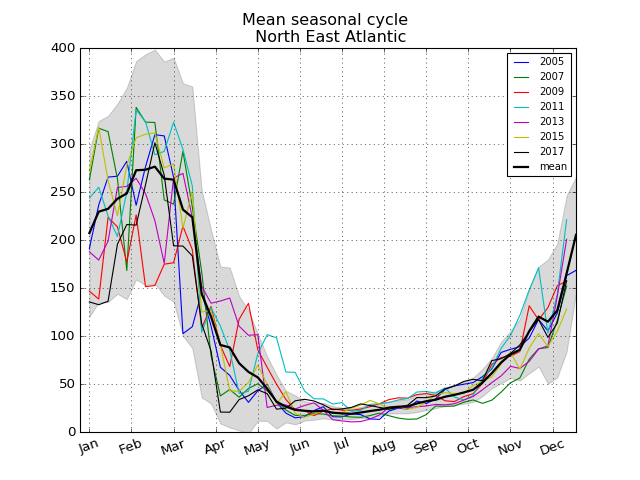

In [11]:
%matplotlib notebook

plt.close()

for i in range(2005, 2018, 2):
    vv = meany_n.mlotst.sel(time=slice('01-01-'+str(i),
                                     '31-12-'+str(i))).groupby('time.week').mean(dim='time')
    plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_n.week.values, mini_n.mlotst, label='mean', linestyle='-', color='k', lw=2)

plt.fill_between(mini_n.week.values, mini_n.mlotst - styd_n.mlotst,
                 mini_n.mlotst + styd_n.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(0, 400)
plt.xticks(np.arange(1, mini_n.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n North East Atlantic')

plt.savefig(dir_o + 'Noe-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()

## Nordic Sea 1

In [16]:
coord = 'nor1'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

nor1 = Crops(coord, c_armor1, regions)
nor12 = Crops(coord, c_armor15, regions)

nor12 = Masking(nor12, nor12.to[0,18])

In [17]:
nor1y = nor1.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
meany_nr1 = nor1y.groupby('time.week').mean(dim=('longitude', 'latitude'))
mini_nr1 =  nor1y.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))
styd_nr1 = nor1y.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))

In [18]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

<IPython.core.display.Javascript object>


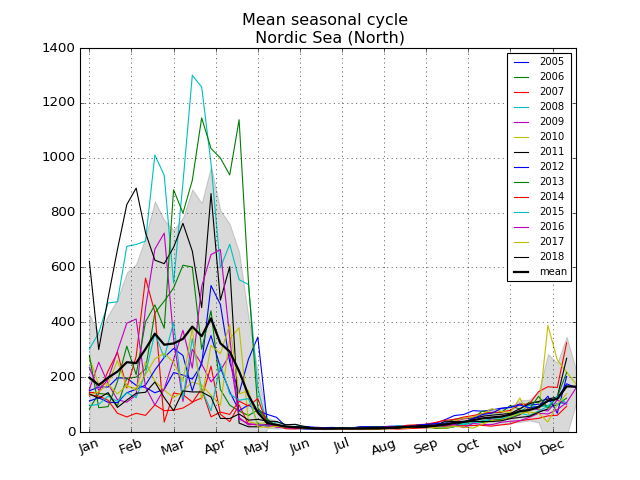

In [24]:
%matplotlib notebook

plt.close()

for i in range(2005, 2019):
    vv = meany_nr1.mlotst.sel(time=slice('01-01-'+str(i),
                                     '31-12-'+str(i))).groupby('time.week').mean(dim='time')
    plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_nr1.week.values, mini_nr1.mlotst, label='mean', linestyle='-', color='k', lw=2)

plt.fill_between(mini_nr1.week.values, mini_nr1.mlotst - styd_nr1.mlotst,
                 mini_nr1.mlotst + styd_nr1.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(0, 1400)
plt.xticks(np.arange(1, mini_nr1.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n Nordic Sea (North)')

plt.savefig(dir_o + 'Nor1-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()

## Nordic Sea 1

In [20]:
coord = 'nor2'
lon1, lon2 = regions[coord]['lon']
lat1, lat2 = regions[coord]['lat']
name_fig = regions[coord]['name'] + '\n MLD Seasonal Cycle'

nor2 = Crops(coord, c_armor1, regions)
nor22 = Crops(coord, c_armor15, regions)

nor22 = Masking(nor22, nor22.to[0,18])

In [21]:
nor2y = nor2.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
meany_nr2 = nor2y.groupby('time.week').mean(dim=('longitude', 'latitude'))
mini_nr2 =  nor2y.groupby('time.week').mean(dim=('longitude', 'latitude', 'time'))
styd_nr2 = nor2y.groupby('time.week').std(dim=('longitude', 'latitude', 'time'))

In [22]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
           

<IPython.core.display.Javascript object>


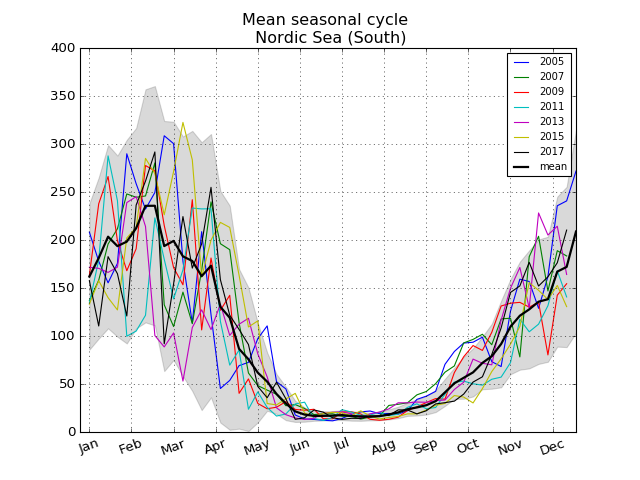

In [27]:
%matplotlib notebook

plt.close()

for i in range(2005, 2019, 2):
    vv = meany_nr2.mlotst.sel(time=slice('01-01-'+str(i),
                                     '31-12-'+str(i))).groupby('time.week').mean(dim='time')
    plt.plot(vv.week.values, vv, label=str(i))
        
plt.plot(mini_nr2.week.values, mini_nr2.mlotst, label='mean', linestyle='-', color='k', lw=2)

plt.fill_between(mini_nr2.week.values, mini_nr2.mlotst - styd_nr2.mlotst,
                 mini_nr2.mlotst + styd_nr2.mlotst, alpha=0.15, color='k')

plt.xlim(0, 53)
plt.ylim(0, 400)
plt.xticks(np.arange(1, mini_nr2.week.size, step=4.5), months, rotation=20)
plt.grid()
plt.legend(fontsize=9)
plt.title('Mean seasonal cycle \n Nordic Sea (South)')

plt.savefig(dir_o + 'Nor2-SeasonalCycle-E.png', bbox_inches='tight')


plt.show()